In [1]:
from qiskit import QuantumCircuit, transpile
import qiskit.quantum_info as qi
import numpy as np
from qiskit.visualization import plot_histogram

In [12]:
# fx = a^x mod 15

def c_amod15(a, power):
    """Controlled multiplication by a mod 15"""
    if a not in [2,4,7,8,11,13]:
        raise ValueError("'a' must be 2,4,7,8,11 or 13")
    U = QuantumCircuit(4)     
    for iteration in range(power):
        if a in [2,13]:
            U.swap(0,1)
            U.swap(1,2)
            U.swap(2,3)
        if a in [7,8]:
            U.swap(2,3)
            U.swap(1,2)
            U.swap(0,1)
        if a in [4, 11]:
            U.swap(1,3)
            U.swap(0,2)
        if a in [7,11,13]:
            for q in range(4):
                U.x(q)
    U = U.to_gate()
    U.name = "%i^%i mod 15" % (a, power)
    c_U = U.control()
    return c_U

In [13]:
n_count = 8
a = 7

In [14]:
#--------------
# qft rotations
#--------------
def qft_rotations(circuit, n):
    if n == 0: # Exit function if circuit is empty
        return circuit
    n -= 1 # Indexes start from 0
    circuit.h(n) # Apply the H-gate to the most significant qubit
    for qubit in range(n):
        circuit.cp(np.pi/2**(n-qubit), qubit, n)
    qft_rotations(circuit, n)
#--------------
# qft swap
#--------------
def swap_registers(circuit, n):
    for qubit in range(n//2):
        circuit.swap(qubit, n-qubit-1)
    return circuit
#--------------
# QFT completo
#--------------
def qft(circuit, n):
    qft_rotations(circuit, n)
    swap_registers(circuit, n)
    return circuit

In [15]:
def inverse_qft(n):
    circuit = QuantumCircuit(n)
    qft_circ = qft(QuantumCircuit(n), n)
    invqft_circ = qft_circ.inverse()
    circuit.append(invqft_circ, circuit.qubits[:n])
    circuit.name = "QFT_dagger"
    return circuit 

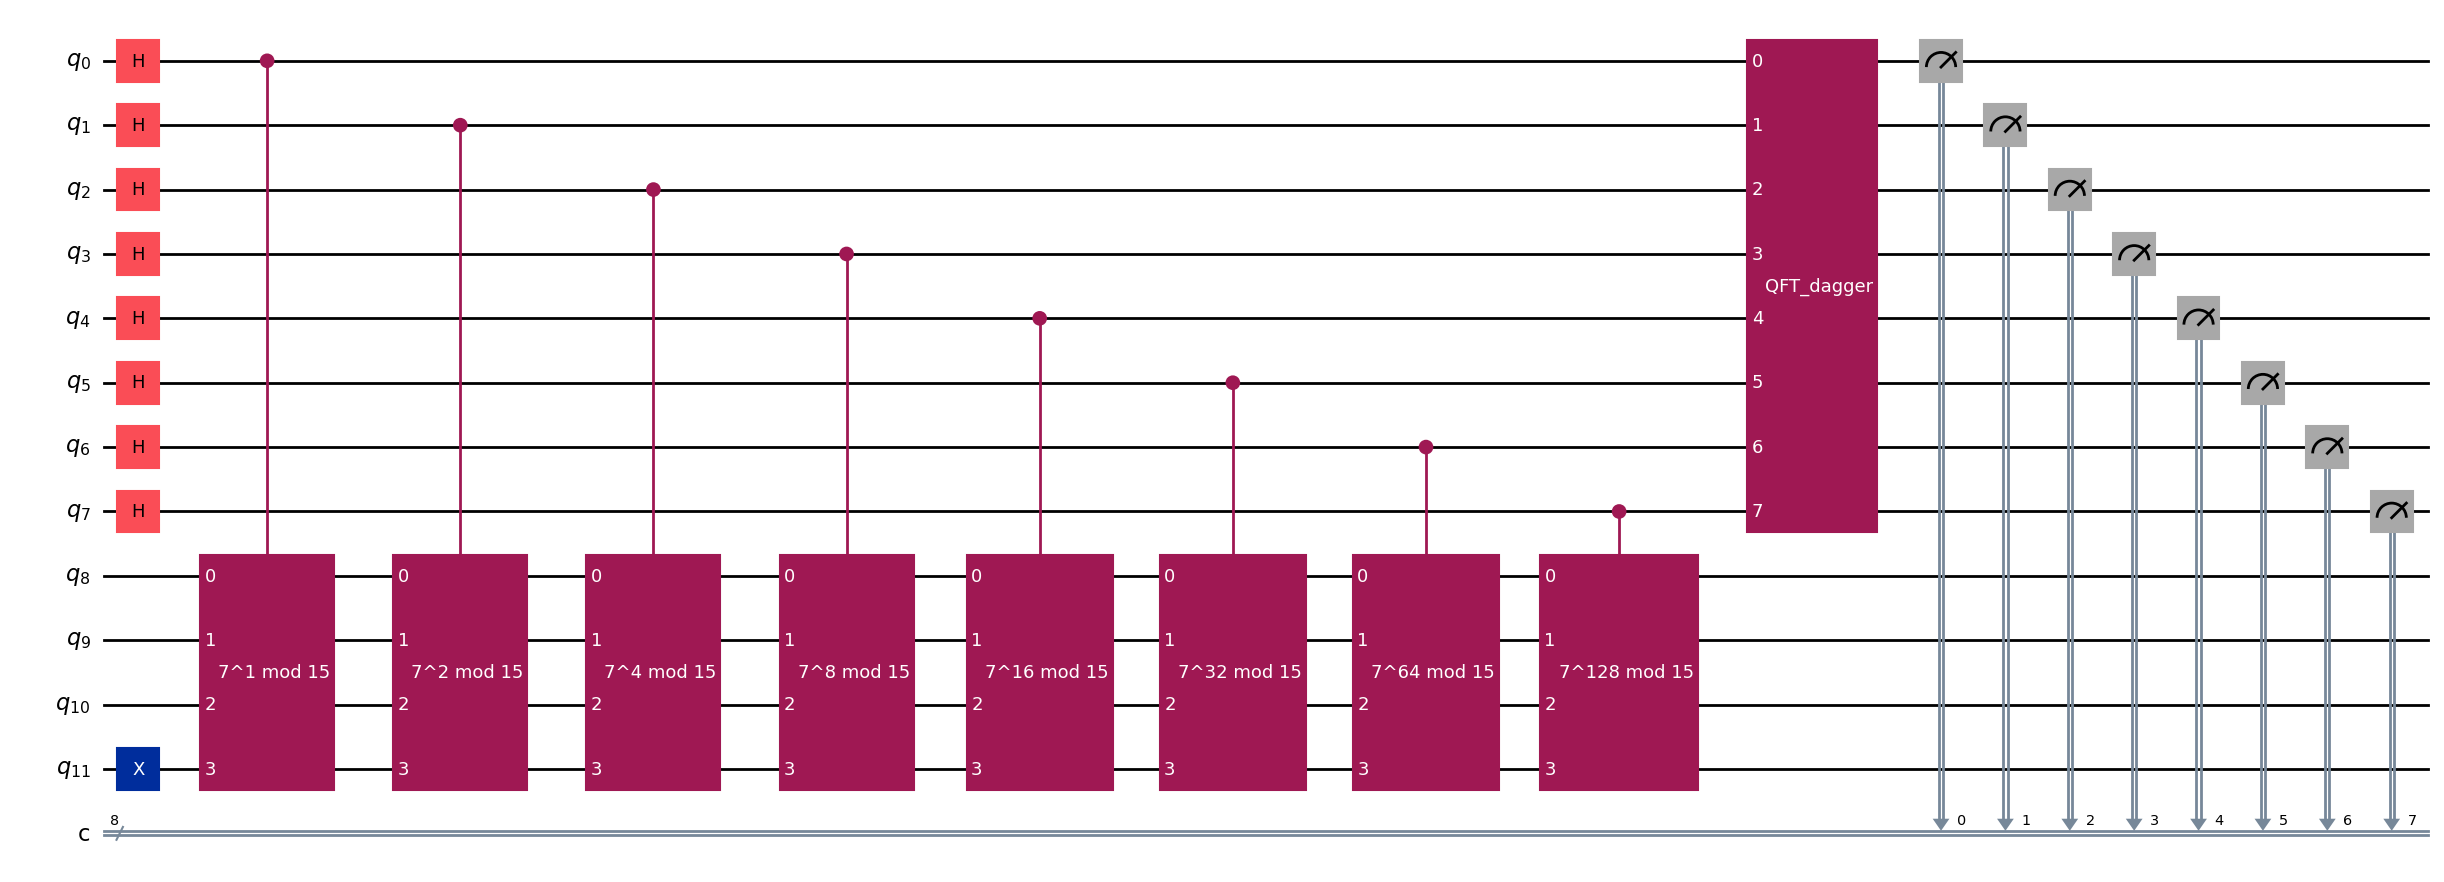

In [16]:
qc = QuantumCircuit(n_count+4, n_count)

for q in range(n_count):
    qc.h(q)    

qc.x(3+n_count)

#operações U-controladas
for q in range(n_count):
    qc.append(c_amod15(a, 2**q), [q] + [i+n_count for i in range(4)])

qc.append(inverse_qft(n_count), range(n_count))

qc.measure(range(n_count), range(n_count))
qc.draw("mpl", fold=-1)

In [17]:
from qiskit.providers.basic_provider import BasicSimulator

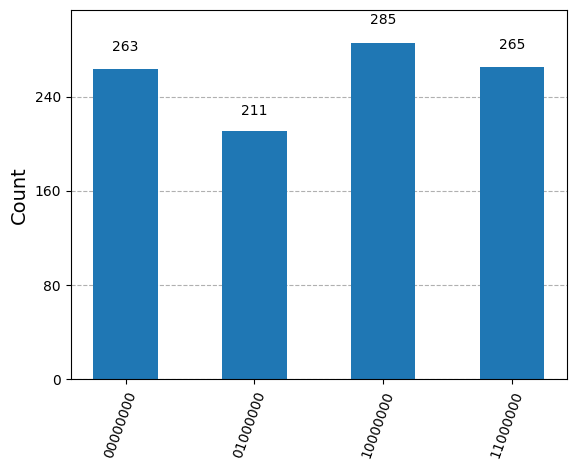

In [18]:
backend = BasicSimulator()
tqc = transpile(qc, backend)
counts = backend.run(tqc).result().get_counts()

plot_histogram(counts)

In [19]:
resp1 = list(counts.items())[0][0]
resp2 = list(counts.items())[1][0]
resp3 = list(counts.items())[2][0]
resp4 = list(counts.items())[3][0]

resp1 = int(resp1,2)/2**n_count 
resp2 = int(resp2,2)/2**n_count 
resp3 = int(resp3,2)/2**n_count 
resp4 = int(resp4,2)/2**n_count 

print(resp1)
print(resp2)
print(resp3)
print(resp4)

0.5
0.75
0.0
0.25


In [20]:
3/4
0
2/4
1/4

0.25